In [1]:
import nlopt
import numpy as np 
from scipy.spatial.transform import Rotation as R
import math
import pandas as pd
import plotly.express as px
import quaternion
import matplotlib.pyplot as plt

In [2]:
'''
These are default values for the projection function. In the future, these will be setup by the engine once at
the start so the projection parameters the engine uses will match these.
'''

SizeX = 1066
SizeY = 496

testP = 2.69191909
ProjectionMatrix = np.array([
    [1, 0,          0,  0],
    [0, 2.69191909, 0,  0],
    [0, 0,          0,  1],
    [0, 0,          10, 0]
])

#For some reason, unreal multiplies the camera's quaternion with this quaternion to get the view rotation matrix...
UnrealsModifierQuat = np.quaternion(0.5, -0.5, 0.5, -0.5)

ForwardStartingQuat = UnrealsModifierQuat*np.quaternion(0.298836, -0.298836, 0.640856, 0.640856)


In [25]:
#Convert vector to rotator

def RotFromVec(vec):
    #print(vec)
    y = math.atan2(vec[1], vec[0]) 
    p = math.atan2(vec[2], math.sqrt(vec[0]**2 + vec[1]**2)) 
    r = 0
    return [p, y, r]


#convert rotator to quaternion:
# phi: roll: r
# theta: pitch: p
# psi: yaw: y
def QuatFromRot(rot):
    #print(rot)
    p = rot[0]
    y = rot[1]
    r = rot[2]
    quat = np.quaternion(
        math.cos(y/2.0)*math.cos(p/2.0)*math.sin(r/2.0) - math.sin(y/2.0)*math.sin(p/2.0)*math.cos(r/2.0),
        math.sin(y/2.0)*math.cos(p/2.0)*math.sin(r/2.0) + math.cos(y/2.0)*math.sin(p/2.0)*math.cos(r/2.0),
        math.sin(y/2.0)*math.cos(p/2.0)*math.cos(r/2.0) - math.cos(y/2.0)*math.sin(p/2.0)*math.sin(r/2.0),
        math.cos(y/2.0)*math.cos(p/2.0)*math.cos(r/2.0) + math.sin(y/2.0)*math.sin(p/2.0)*math.sin(r/2.0),
    )
    return quat


UnrealsModifierQuat*QuatFromRot([0, -90*math.pi/180, 0])
#[ 0.7071068, 0, 0, 0.7071068 ]

quaternion(0.707106781186548, 0, 0, 0.707106781186548)

In [4]:
'''
These varaibles might change between engine calls
'''


#This is the starting camera position for the CloserObject experiment 
#(I'm using this to compare the outputs of my functions with Unreal's)
#For some reason, the z axis is must be inverted
CameraPosition = [465, -1300, 200]
Points = [
    [462, -310, 19],
    [1000.0, -234.653137, -100],
    [462, -56, 81],
    [413, -67, 19],
    [513, 220, 19]
]

PointsColors = ["red", "green", "black", "blue", "yellow"]

PointsCenter = [0, 0, 0]
for i in range(len(Points)):
    PointsCenter[0] += Points[i][0]
    PointsCenter[1] += Points[i][1]
    PointsCenter[2] += Points[i][2]

PointsCenter[0] = PointsCenter[0]/len(Points)
PointsCenter[1] = PointsCenter[1]/len(Points)
PointsCenter[2] = PointsCenter[2]/len(Points)

rot = RotFromVec([PointsCenter[0] - CameraPosition[0], PointsCenter[1] - CameraPosition[1], PointsCenter[2] - CameraPosition[2]])
CenterLookingQuat = UnrealsModifierQuat*QuatFromRot(rot)

#CenterLookingQuat = np.quaternion(0, 0.7071068, 0.7071068, 0)

print(CenterLookingQuat)
print (PointsCenter)


quaternion(0.0280890303976772, 0.648852383294333, 0.759684169887187, 0.0328869744336219)
[570.0, -89.5306274, 7.6]


In [5]:
def GetTranslationMatrix(Position):
    return np.array([
        [1,             0,           0,           0],
        [0,             1,           0,           0],
        [0,             0,           1,           0],
        [-Position[0], -Position[1], Position[2] ,1]
    ])

In [26]:
'''
This is a helper function that will provide a rotation matrix from a quaternion
example input: [0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]
'''
def GetRotationMatrixFromQuat(q):
    #print(q)
    r = R.from_quat([q.w, q.x, q.y, q.z]).as_dcm()
    mat = np.array([
        [r[0][0], r[0][1], r[0][2], 0],
        [r[1][0], r[1][1], r[1][2], 0],
        [r[2][0], r[2][1], r[2][2], 0],
        [0      , 0      , 0      , 1]
    ])
    return mat

In [7]:
def ProjectWorldLocationToScreen(WorldLocation, ViewOrigin, ViewQuat):
    #print(WorldLocation)
    WorldLocation = np.array([WorldLocation[0], WorldLocation[1], WorldLocation[2], 1])
    TranslationMatrix = GetTranslationMatrix(ViewOrigin)
    # This is the final matrix that encodes the position, rotation, and projection of the camera 
    ViewProjectionMatrix = TranslationMatrix.dot(GetRotationMatrixFromQuat(ViewQuat)).dot(ProjectionMatrix)
    #print(ViewProjectionMatrix)
    Pos = WorldLocation.dot(ViewProjectionMatrix)
    #print(Pos)
    if (Pos[3] > 0):
        Pos = Pos/Pos[3]
        NormalizedX = ((Pos[0]/2.0) + 0.5)
        NormalizedY = (1.0 - (Pos[1]/2.0) - 0.5)
        if (NormalizedX < 0 or NormalizedX > 1):
            return False
        if (NormalizedY < 0 or NormalizedY > 1):
            return False
        Pos = [NormalizedX*SizeX, NormalizedY*SizeY]
        return Pos
    else:
        return False
    

In [8]:
def PlotPoints2D(Pos, Quat):
    lostPoints = 0
    for i in range(len(Points)):
        p = ProjectWorldLocationToScreen(Points[i], Pos, Quat)
        if (p):
            print(p)
            plt.scatter(p[0], p[1], c=PointsColors[i])
        else:
            lostPoints+=1
    print("Lost %i points" % lostPoints)
    
    plt.ylim(SizeY, 0)
    plt.xlim(0, SizeX)
    plt.show()    

In [9]:
'''
What defines the output of this function (given the projection matrix, and points in 3d space) is
the cameras position: ViewOriging, and its rotation: ViewRotationMatrix. I want to create this function first
and compare its results with Unreal's results as a sanity check.
'''

def GetDistanceSum(ViewOrigin, ViewRotationMatrix):
    Sum = 0
    for i in range(len(Points)):
        ithPos = ProjectWorldLocationToScreen(Points[i])
        for j in range(i, len(Points)):
            #print("%i, %i:" % (i, j))
            jthPos = ProjectWorldLocationToScreen(Points[j])
            Sum += math.sqrt((ithPos[0] - jthPos[0])**2 + (ithPos[1] - jthPos[1])**2)
            #print("%f" % Sum)
            
    return Sum

In [54]:
def dist2D(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
'''
This is the function that I will optimize as an excersice once I get the previous functions to
work flawlessly.
'''

pointInroductionReward = 100
pointRemovalPunishment = -100

OldPosition = CameraPosition

def SumDifference(pos, grad):
    Sum = 0
    c = PointsCenter
    rot = RotFromVec([c[0] - OldPosition[0], c[1] - OldPosition[1], c[2] - OldPosition[2]])
    OldQuat = UnrealsModifierQuat*QuatFromRot(rot)
    
    for i in range(len(Points)):
        oldPosI = ProjectWorldLocationToScreen(Points[i], OldPosition, OldQuat)
        newPosI = ProjectWorldLocationToScreen(Points[i], pos, OldQuat)
        if (newPosI):
            for j in range(i, len(Points)):
                oldPosJ = ProjectWorldLocationToScreen(Points[j], OldPosition, OldQuat)
                newPosJ = ProjectWorldLocationToScreen(Points[j], pos, OldQuat)
                if (newPosJ):
                    Sum += abs(dist2D(oldPosI, oldPosJ) - dist2D(newPosI, newPosJ))
        else:
            pass
            #print("cant see point %i" % i)
    return Sum

def SumDifferenceWithOrientation(pos, grad):

    Sum = 0
    c = PointsCenter
    
    rot = RotFromVec([c[0] - OldPosition[0], c[1] - OldPosition[1], c[2] - OldPosition[2]])
    if (rot[0] == np.NaN):
        print("something went wrong")
        print(c)
        print(pos)
        print(rot)
    OldQuat = UnrealsModifierQuat*QuatFromRot(rot)
    
    rot = RotFromVec([c[0] - pos[0], c[1] - pos[1], c[2] - pos[2]])
    if (rot[0] == np.NaN):
        print("something went wrong")
        print(c)
        print(pos)
        print(rot)
    OrientationQuat = UnrealsModifierQuat*QuatFromRot(rot)
    
    
    for i in range(len(Points)):
        oldPosI = ProjectWorldLocationToScreen(Points[i], OldPosition, OldQuat)
        newPosI = ProjectWorldLocationToScreen(Points[i], pos, OrientationQuat)
        if (newPosI):
            #print(newPosI)
            for j in range(i, len(Points)):
                oldPosJ = ProjectWorldLocationToScreen(Points[j], OldPosition, OldQuat)
                newPosJ = ProjectWorldLocationToScreen(Points[j], pos, OrientationQuat)
                if (newPosJ):
                    Sum += abs(dist2D(oldPosI, oldPosJ) - dist2D(newPosI, newPosJ))
        else:
            #print('Point lost :(')
            Sum -= 5000
            
    return Sum

In [11]:
c = PointsCenter
rot = RotFromVec([c[0] - y[0], c[1] - y[1], c[2] - y[2]])
OldQuat = UnrealsModifierQuat*QuatFromRot(rot)

ProjectWorldLocationToScreen(Points[1], y, OldQuat)
#SumDifferenceWithOrientation([684.0575483,  -231.87961921,  188.89734238], [])

NameError: name 'y' is not defined

In [12]:
pos = ProjectWorldLocationToScreen([474, -900, -41], [-700, 900, 0], ForwardStartingQuat)
if (pos):
    print(pos)
else:
    print("Point not in view")

Point not in view


In [14]:
x = [point[0] for point in Points]
y = [point[1] for point in Points]
z = [point[2] for point in Points]

x.append(CameraPosition[0])
y.append(CameraPosition[1])
z.append(CameraPosition[2])

fig = px.scatter_3d(x=x, y=y, z=z)

fig.show()

[-8.99818528 85.04238959  0.        ]
[465, -1300, 200]
[579.8118447499716, 206.88722803827952]
[321.1974767497841, 292.8002719203444]
[579.4534701264757, 203.90141310070058]
[600.9002799196861, 234.63609080429075]
[562.0247125357074, 257.2205842667228]
Lost 0 points


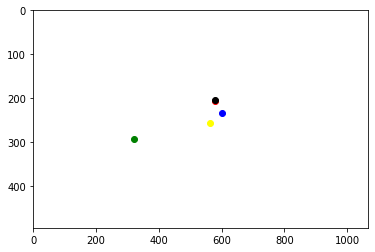

In [15]:
c = PointsCenter
rot = RotFromVec([c[0] - CameraPosition[0], c[1] - CameraPosition[1], c[2] - CameraPosition[2]])
quat = UnrealsModifierQuat*QuatFromRot(rot)

print(np.array(rot)*180.0/math.pi)
print(CameraPosition)

PlotPoints2D(CameraPosition, quat)

[4.07883284 9.36447344 0.        ]
[-310, -234.653137, -56, -67, 220, -1300]
[390.93153566198635, 233.40423423591855]
[445.6306807744874, 280.6864674594037]
[567.3076646384302, 179.13318541820578]
[567.3470041013416, 233.7953846853066]
[722.2203690170574, 228.33154914450768]
Lost 0 points


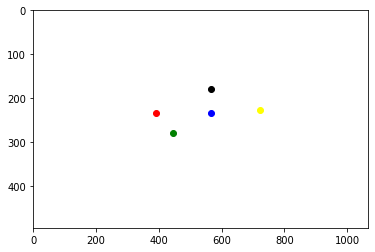

In [16]:
c = PointsCenter
rot = RotFromVec([c[0] - y[0], c[1] - y[1], c[2] - y[2]])
quat = UnrealsModifierQuat*QuatFromRot(rot)

print(np.array(rot)*180.0/math.pi)
print(y)
#late result = -310, -234.653137, -56
PlotPoints2D(y, quat)

In [50]:
OldPosition = CameraPosition

opt = nlopt.opt(nlopt.LN_NELDERMEAD, 3)
opt.set_max_objective(SumDifference)
x = opt.optimize(CameraPosition)
opt_val = opt.last_optimum_value()

print(x)
print(opt_val)

[ 3.58675317e+17 -1.40926142e+18  1.19951917e+17]
1304.5443182225304


In [58]:
OldPosition = CameraPosition

opt = nlopt.opt(nlopt.LN_NELDERMEAD, 3)
opt.set_max_objective(SumDifferenceWithOrientation)
opt.set_lower_bounds([CameraPosition[0] - 500, CameraPosition[1] - 500, CameraPosition[2] - 500])
opt.set_upper_bounds([CameraPosition[0] + 500, CameraPosition[1] + 500, CameraPosition[2] + 500])
y = opt.optimize(CameraPosition)
val = opt.last_optimum_value()

print(y)
print(val)
print(SumDifferenceWithOrientation(y, []))

[ 769.77137233 -800.         -104.72922565]
1384.351636355586
1384.351636355586


In [18]:
opt.last_optimize_result()

-5

[688.3129271151914, 249.47362633788032]
[139.30854545466008, 418.94371553316665]
[596.699346863159, 166.57102187843867]
[628.9166906876629, 218.21781986920132]
[518.3559091563948, 201.40125328745876]
Lost 0 points


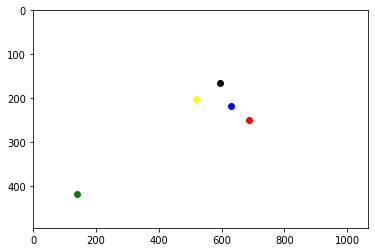

In [59]:
c = PointsCenter

rot = RotFromVec([c[0] - y[0], c[1] - y[1], c[2] - y[2]])
quat = UnrealsModifierQuat*QuatFromRot(rot)


PlotPoints2D(y, quat)

[ 1269.77137233 -1300.           395.27077435]
1565.5660176395659
[614.9244984372289, 216.69463437664612]
[387.51903989110036, 246.76578158792609]
[559.3021839416583, 220.8693470825758]
[575.7914502019082, 248.2465395924946]
[500.7318724390577, 268.516320149109]
Lost 0 points


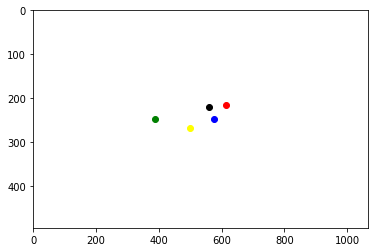

In [61]:
OldPosition = y
opt.set_lower_bounds([y[0] - 500, y[1] - 500, y[2] - 500])
opt.set_upper_bounds([y[0] + 500, y[1] + 500, y[2] + 500])
z = opt.optimize(y)
zVal = opt.last_optimum_value()

print(z)
print(zVal)

c = PointsCenter

rot = RotFromVec([c[0] - z[0], c[1] - z[1], c[2] - z[2]])
quat = UnrealsModifierQuat*QuatFromRot(rot)


PlotPoints2D(z, quat)

[1769.77137233 -800.          308.57684167]
532.7699400204523
[625.3089822086807, 233.7816557151259]
[481.3837927794484, 245.70230620067989]
[541.9862803052039, 220.74358908180426]
[553.5067398131455, 250.0868984775857]
[455.60556635640626, 255.19995662867726]
Lost 0 points


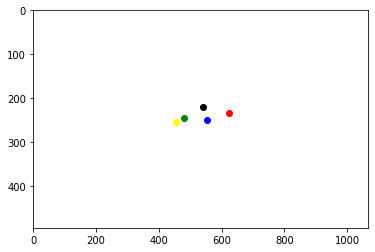

In [62]:
OldPosition = z
opt.set_lower_bounds([z[0] - 500, z[1] - 500, z[2] - 500])
opt.set_upper_bounds([z[0] + 500, z[1] + 500, z[2] + 500])
w = opt.optimize(z)
wVal = opt.last_optimum_value()

print(w)
print(wVal)

c = PointsCenter

rot = RotFromVec([c[0] - w[0], c[1] - w[1], c[2] - w[2]])
quat = UnrealsModifierQuat*QuatFromRot(rot)


PlotPoints2D(w, quat)

In [40]:
SumDifferenceWithOrientation(y, [])

4016.479467578431